In [1]:
import yfinance as yf
import pandas as pd
import os
from curl_cffi import requests

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    session = requests.Session(impersonate="chrome")
    sp500 = yf.Ticker("SPY", session=session)
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.397774,24.397774,24.276392,24.380434,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,24.397788,24.553850,24.397788,24.553850,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,24.536501,24.623202,24.484480,24.605862,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,24.640545,24.883309,24.623205,24.865969,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,24.952665,25.022026,24.675220,24.970005,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-08-11 00:00:00-04:00,637.460022,638.950012,634.659973,635.919983,58742300,0.0,0.0,0.0
2025-08-12 00:00:00-04:00,638.289978,642.849976,636.789978,642.690002,64730800,0.0,0.0,0.0
2025-08-13 00:00:00-04:00,644.909973,646.190002,642.679993,644.890015,60092800,0.0,0.0,0.0


<Axes: xlabel='Date'>

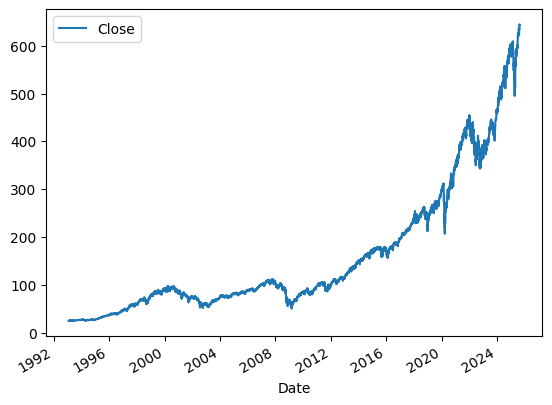

In [5]:
sp500.plot.line(y="Close", use_index=True)

In [6]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [9]:
sp500 = sp500.loc["1990-01-01":].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5964912280701754

<Axes: xlabel='Date'>

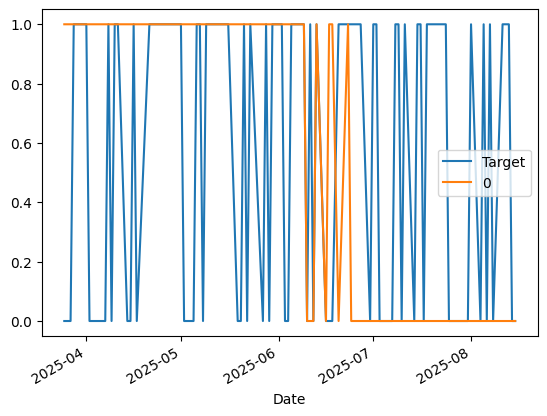

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [15]:
predictions = backtest(sp500, model, predictors)

In [16]:
predictions["Predictions"].value_counts()

Predictions
1    3196
0    2497
Name: count, dtype: int64

In [17]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5422403003754693

In [18]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.552082
0    0.447918
Name: count, dtype: float64

In [19]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [20]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [21]:
sp500

,Open,High,Low,Close,Volume,Capital Gains,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
1997-01-14 00:00:00-05:00,46.730552,47.159011,46.616297,46.901936,2111200,0.0,46.787701,0,1.006230,1.0,1.015126,3.0,1.047089,36.0,1.147327,135.0,1.494512,527.0
1997-01-15 00:00:00-05:00,46.749615,47.044776,46.540147,46.787701,1583900,0.0,46.978092,1,0.998781,1.0,1.007091,3.0,1.043141,35.0,1.143393,134.0,1.489817,526.0
1997-01-16 00:00:00-05:00,46.940007,47.101869,46.616283,46.978092,1308400,0.0,47.263725,1,1.002031,1.0,1.006487,3.0,1.045889,36.0,1.146883,134.0,1.494814,526.0
1997-01-17 00:00:00-05:00,47.044735,47.377981,46.987608,47.263725,1604000,0.0,47.320843,1,1.003031,2.0,1.008820,3.0,1.050519,37.0,1.152667,134.0,1.502832,526.0
1997-01-20 00:00:00-05:00,47.377971,47.587439,47.206587,47.320843,1889900,0.0,47.701714,1,1.000604,2.0,1.005747,4.0,1.050095,37.0,1.152899,134.0,1.503580,526.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-11 00:00:00-04:00,637.460022,638.950012,634.659973,635.919983,58742300,0.0,642.690002,1,0.999010,1.0,1.004264,2.0,1.039879,34.0,1.093910,146.0,1.362349,538.0
2025-08-12 00:00:00-04:00,638.289978,642.849976,636.789978,642.690002,64730800,0.0,644.890015,1,1.005295,1.0,1.010258,3.0,1.049406,34.0,1.104674,146.0,1.376195,539.0
2025-08-13 00:00:00-04:00,644.909973,646.190002,642.679993,644.890015,60092800,0.0,644.950012,1,1.001709,2.0,1.009872,3.0,1.051498,34.0,1.107621,146.0,1.380226,540.0


In [22]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [24]:
predictions = backtest(sp500, model, new_predictors)

In [25]:
predictions["Predictions"].value_counts()

Predictions
0.0    4015
1.0     678
Name: count, dtype: int64

In [26]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5457227138643068

In [27]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.550394
0    0.449606
Name: count, dtype: float64

In [28]:
predictions

,Target,Predictions
Date,,
2006-12-19 00:00:00-05:00,0,1.0
2006-12-20 00:00:00-05:00,0,1.0
2006-12-21 00:00:00-05:00,0,0.0
2006-12-22 00:00:00-05:00,1,0.0
2006-12-26 00:00:00-05:00,1,1.0
...,...,...
2025-08-11 00:00:00-04:00,1,0.0
2025-08-12 00:00:00-04:00,1,0.0
2025-08-13 00:00:00-04:00,1,0.0
